In [6]:

import torch
import argparse
from pathlib import Path
import numpy as np
from src.model_utils import build_model
import src.datasets as datasets
import src.evaluation as evaluation
from src.torch_utils import torch2numpy
from reevaluate import get_test_dataset
from tqdm import tqdm
#from conformal import aci


In [86]:
from statsmodels.regression.quantile_regression import QuantReg


def ACI(Y, X, alpha, gamma, t_init=500, split_size=0.75, update_method="Simple", momentum_bw=0.95):
    T = len(Y)
    # Initialize data storage variables
    alpha_trajectory = [alpha] * (T - t_init)
    adapt_err_seq = [0] * (T - t_init)
    no_adapt_error_seq = [0] * (T - t_init)
    alpha_t = alpha
    band_native = []
    band_adapt = []
    
    for t in range(t_init, T):
        # Split data into training and calibration set
        train_points = np.random.choice(t, size=int(split_size*t), replace=False)
        cal_points = np.setdiff1d(np.arange(t), train_points)
        X_train, Y_train = X[train_points], Y[train_points]
        X_cal, Y_cal = X[cal_points], Y[cal_points]
        
        # Fit quantile regression on training setting
        model_upper = QuantReg(Y_train, X_train)
        model_lower = QuantReg(Y_train, X_train)
        res_upper = model_upper.fit(q=1-alpha/2)
        res_lower = model_lower.fit(q=alpha/2)
        
        # Compute conformity score on calibration set and on new data example
        pred_low_for_cal = res_lower.predict(X_cal)
        pred_up_for_cal = res_upper.predict(X_cal)
        scores = np.maximum(Y_cal - pred_up_for_cal, pred_low_for_cal - Y_cal)
        q_up = res_upper.predict(X[t].reshape(1, -1))[0]
        q_low = res_lower.predict(X[t].reshape(1, -1))[0]
        new_score = max(Y[t] - q_up, q_low - Y[t])
        
        # Compute errt for both methods
        conf_quant_naive = np.quantile(scores, 1-alpha)
        no_adapt_error_seq[t-t_init] = float(conf_quant_naive < new_score)
        band_native.append(conf_quant_naive)
        
        if alpha_t >= 1:
            adapt_err_seq[t-t_init] = 1
            band_adapt.append(0)
        elif alpha_t <= 0:
            adapt_err_seq[t-t_init] = 0
            band_adapt.append(10)
        else:
            conf_quant_adapt = np.quantile(scores, 1-alpha_t)
            adapt_err_seq[t-t_init] = float(conf_quant_adapt < new_score)
            band_adapt.append(conf_quant_adapt)
        # update alpha_t
        alpha_trajectory[t-t_init] = alpha_t
        if update_method == "Simple":
            alpha_t += gamma * (alpha - adapt_err_seq[t-t_init])
        elif update_method == "Momentum":
            w = momentum_bw ** np.arange(t-t_init+1)[::-1]
            w /= w.sum()
            alpha_t += gamma * (alpha - np.sum(adapt_err_seq[:t-t_init+1] * w))
        
        if t % 100 == 0:
            print(f"Done {t} time steps")
    
    return alpha_trajectory, adapt_err_seq, no_adapt_error_seq, (band_native, band_adapt)


In [8]:
preds = np.load("./results/bouncing_ball_noisy_test.npz", allow_pickle=True)
ground_truth = preds["ground_truth"]
mean = preds["mean"]


In [88]:
def creat_x_y(dataset_path, context_length=10):

    #test_dataset = get_test_dataset(config)
    test_dataset = datasets.BouncingBallDataset(path=dataset_path)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20)

    #do predictions autoregressively. 
    context_length = context_length
    Xs = []
    Ys = []
    # calculate coverage and width of prediction intervals
    for test_batch, test_label in tqdm(test_loader):
       #print(test_batch.shape)
        prediction_length = test_batch.shape[1]-context_length

        X = []
        Y = []
        for t in range(prediction_length):
            X.append(test_batch[:, t:t+context_length].numpy())
            Y.append(test_label[:, t+context_length].numpy())
        
        Xs.append(np.array(X).swapaxes(0, 1).squeeze())
        Ys.append(np.array(Y).swapaxes(0, 1))

    return np.concatenate(Xs, 0), np.concatenate(Ys, 0)

In [59]:
Xs, Ys = creat_x_y("./data/bouncing_ball_test_1000.npz")

100%|██████████| 50/50 [00:00<00:00, 123.01it/s]


In [60]:
Xs.shape, Ys.shape

((1000, 990, 10), (1000, 990))

In [87]:
Xs, Ys = creat_x_y("./data/bouncing_ball_test_1000.npz")
print(Xs.shape, Ys.shape)
alpha_trajectories = []
adapt_err_seqs = []
no_adapt_error_seqs = []
band_natives = []
band_adapts = []
for i in tqdm(range(100)):
    X, Y = Xs[i], Ys[i]
    alpha_trajectory, adapt_err_seq, no_adapt_error_seq, (band_native, band_adapt) = ACI(Y, X, alpha=0.1, gamma=0.01, t_init=100)
    alpha_trajectories.append(alpha_trajectory)
    adapt_err_seqs.append(adapt_err_seq)
    no_adapt_error_seqs.append(no_adapt_error_seq)
    band_natives.append(band_native)
    band_adapts.append(band_adapt)

100%|██████████| 50/50 [00:00<00:00, 124.28it/s]


(1000, 990, 10) (1000, 990)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
  5%|▌         | 5/100 [03:16<1:00:17, 38.08s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
  6%|▌         | 6/100 [03:44<54:22, 34.71s/it]  

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
  8%|▊         | 8/100 [04:57<53:47, 35.09s/it]/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 14%|█▍        | 14/100 [08:11<46:52, 32.71s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 15%|█▌        | 15/100 [08:41<45:19, 32.00s/it]/usr/local/Caskroom/miniforge/ba

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 17%|█▋        | 17/100 [09:40<42:19, 30.60s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 18%|█▊        | 18/100 [10:13<43:00, 31.47s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 19%|█▉        | 19/100 [10:43<41:40, 30.87s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 21%|██        | 21/100 [11:37<38:00, 28.86s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

KeyboardInterrupt: 

In [ ]:
1- np.mean(adapt_err_seqs), 1-np.mean(no_adapt_error_seqs)

(0.9013370786516854, 0.8758876404494382)

In [ ]:
np.std(np.mean(adapt_err_seqs, axis=1)), np.std(np.mean(no_adapt_error_seqs, axis=1))


(0.004917434696510483, 0.0767547194556617)

In [ ]:
np.mean(band_natives), np.std(np.mean(band_natives, axis=1)), np.mean(band_adapts), np.std(np.mean(band_adapts, axis=1))

In [ ]:
np.savez("./results/bouncing_ball_aci.npz", alpha_trajectories=alpha_trajectories, adapt_err_seqs=adapt_err_seqs, no_adapt_error_seqs=no_adapt_error_seqs, band_natives=band_natives, band_adapts=band_adapts)

In [89]:
# compile this into a function
def ACI_from_dataset(dataset_path, context_length=10, test_size=100):
    Xs, Ys = creat_x_y(dataset_path, context_length=context_length)
    print(Xs.shape, Ys.shape)

    dataset_name = dataset_path.split("/")[-1].split(".")[0]
    alpha_trajectories = []
    adapt_err_seqs = []
    no_adapt_error_seqs = []
    band_natives = []
    band_adapts = []

    if test_size <= 0:
        test_size = Xs.shape[0]

    for i in tqdm(range(test_size)):
        X, Y = Xs[i], Ys[i]
        alpha_trajectory, adapt_err_seq, no_adapt_error_seq, (band_native, band_adapt) = ACI(Y, X, alpha=0.1, gamma=0.01, t_init=100)
        alpha_trajectories.append(alpha_trajectory)
        adapt_err_seqs.append(adapt_err_seq)
        no_adapt_error_seqs.append(no_adapt_error_seq)
        band_natives.append(band_native)
        band_adapts.append(band_adapt)

    np.savez(f"./results/{dataset_name}_aci.npz", 
             alpha_trajectories=alpha_trajectories, 
             adapt_err_seqs=adapt_err_seqs, 
             no_adapt_error_seqs=no_adapt_error_seqs, 
             band_natives=band_natives, 
             band_adapts=band_adapts)
    
    cov_adapt, cov_no_adapt = 1-np.mean(adapt_err_seqs), 1-np.mean(no_adapt_error_seqs)
    std_adapt, std_no_adapt = np.std(np.mean(adapt_err_seqs, axis=1)), np.std(np.mean(no_adapt_error_seqs, axis=1))
    mean_band_native, std_band_native = np.mean(band_natives), np.std(np.mean(band_natives, axis=1))
    mean_band_adapt, std_band_adapt = np.mean(band_adapts), np.std(np.mean(band_adapts, axis=1))
    
    print(f"Adaptive Coverage: {cov_adapt} +/- {std_adapt}")
    print(f"No Adaptive Coverage: {cov_no_adapt} +/- {std_no_adapt}")
    print(f"Adaptive Width: {mean_band_adapt} +/- {std_band_adapt}")
    print(f"No Adaptive Width: {mean_band_native} +/- {std_band_native}")
    return cov_adapt, std_adapt, cov_no_adapt, std_no_adapt, mean_band_native, std_band_native, mean_band_adapt, std_band_adapt

In [ ]:
Xs, Ys = creat_x_y("./data/bouncing_ball_noisy_test_1000.npz")
print(Xs.shape, Ys.shape)
alpha_trajectories = []
adapt_err_seqs = []
no_adapt_error_seqs = []
band_natives = []
band_adapts = []
for i in tqdm(range(100)):
    X, Y = Xs[i], Ys[i]
    alpha_trajectory, adapt_err_seq, no_adapt_error_seq, (band_native, band_adapt) = ACI(Y, X, alpha=0.1, gamma=0.01, t_init=100)
    alpha_trajectories.append(alpha_trajectory)
    adapt_err_seqs.append(adapt_err_seq)
    no_adapt_error_seqs.append(no_adapt_error_seq)
    band_natives.append(band_native)
    band_adapts.append(band_adapt)

In [78]:
X, Y = Xs[5], Ys[5]

alpha_trajectory, adapt_err_seq, no_adapt_error_seq = ACI(Y, X, alpha=0.1, gamma=0.01, t_init=100)


Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

In [79]:
np.mean(adapt_err_seq), np.mean(no_adapt_error_seq)

(0.10224719101123596, 0.11348314606741573)

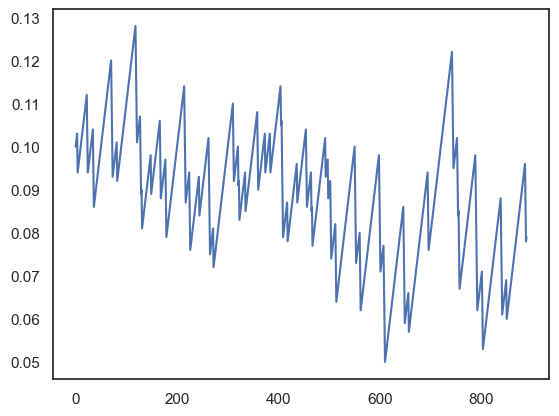

In [80]:
from matplotlib import pyplot as plt
plt.plot(alpha_trajectory)

In [68]:
import seaborn as sns
seed = 111
np.random.seed(seed)
sns.set(style="white")

color_names = ["red",
               "windows blue",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "light cyan",
               "steel blue",
               "pastel purple",
               "mint",
               "salmon"]

colors = sns.xkcd_palette(color_names)
def _plot_segments(ax, segmentation, ymin, ymax):
    s_seq = np.squeeze(segmentation)
    z_cps = np.concatenate(
        ([0], np.where(np.diff(s_seq))[0]+1, [s_seq.size]))
    for start, stop in zip(z_cps[:-1], z_cps[1:]):
        stop = min(s_seq.size, stop+1)
        ax.axvspan(
            start, stop-1, ymin=ymin, ymax=ymax,
            alpha=.8, facecolor=colors[s_seq[start]])

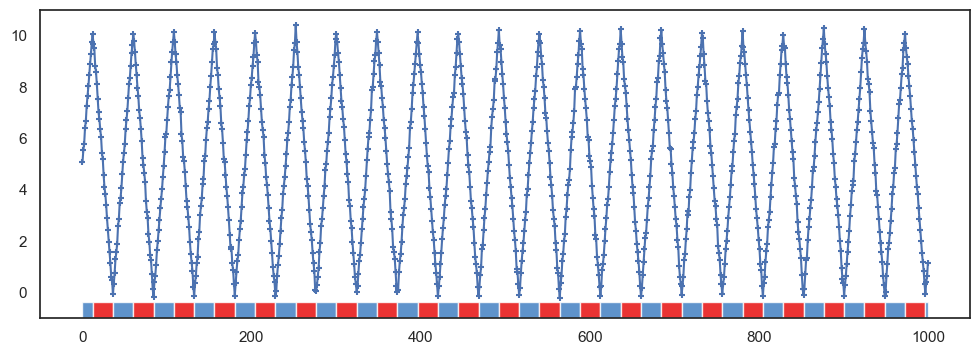

In [77]:
ball = np.load('./data/bouncing_ball_test_1000.npz')
data_y = ball['y']
data_z = ball['z']

idx = 5 #np.random.randint(data_y.shape[0])
y_seq, z_seq = data_y[idx], data_z[idx]
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()
ax.scatter(np.arange(len(y_seq)), y_seq, s=25, marker='+')
ax.plot(np.arange(len(y_seq)), y_seq)
ax.set_ylim([-1, 11.])
_plot_segments(ax, z_seq, 0., 0.05)
plt.show()

In [48]:
ckpt_bb = "./Checkpoints/bouncing_ball.pt"
ckpt_bbnoisy = "./Checkpoints/bb_noisy.pt"


In [50]:
#calculate errors on the calibration dataset

preds = np.load("./results/bouncing_ball_calibration.npz", allow_pickle=True)
ground_truth = preds["ground_truth"]
mean = preds["mean"]


In [52]:
mses = (ground_truth.squeeze() - mean) ** 2
mses.shape

(3000, 50)

In [56]:
# vanilla cp
nonconformity = mses.flatten()

# get quantiles of nonconformity scores
alpha = 0.1
thresh = np.quantile(nonconformity, 1-alpha)


In [57]:
# inference on test set
ground_truth, all_mean = inference(ckpt_bb, "./data/bouncing_ball_test.npz")
np.savez("./results/bouncing_ball_test.npz", ground_truth=ground_truth, mean=all_mean)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 50/50 [02:39<00:00,  3.18s/it]


In [66]:
test_mses = (ground_truth.squeeze() - all_mean) ** 2
test_nonconformity = test_mses.flatten()
coverage = np.mean(test_nonconformity < thresh)


In [67]:
coverage, thresh

(0.90404, 0.23606456667184836)

## Noisey

In [1]:
#calculate errors on the calibration dataset

preds = np.load("./results/bouncing_ball_noisy_calibration.npz", allow_pickle=True)
ground_truth = preds["ground_truth"]
mean = preds["mean"]


NameError: name 'np' is not defined

In [71]:
mean[0].shape

torch.Size([1, 80, 1])

In [69]:
mses = (ground_truth.squeeze() - mean) ** 2
mses.shape

ValueError: operands could not be broadcast together with shapes (3000,50) (1900,) 

In [ ]:
# vanilla cp
nonconformity = mses.flatten()

# get quantiles of nonconformity scores
alpha = 0.1
thresh = np.quantile(nonconformity, 1-alpha)


In [ ]:
# inference on test set
ground_truth, all_mean = inference(ckpt_bb, "./data/bouncing_ball_test.npz")
np.savez("./results/bouncing_ball_test.npz", ground_truth=ground_truth, mean=all_mean)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 50/50 [02:39<00:00,  3.18s/it]


In [ ]:
test_mses = (ground_truth.squeeze() - all_mean) ** 2
test_nonconformity = test_mses.flatten()
coverage = np.mean(test_nonconformity < thresh)


In [ ]:
coverage, thresh

(0.90404, 0.23606456667184836)

## Forcasting

In [ ]:

pred_segs = []
true_segs = []
for test_batch, test_label in tqdm(test_loader):
    test_batch = test_batch.to(device)
    pred = model.predict(test_batch, num_samples=100)
    true = test_batch[:, config['context_length']:]
    pred_segs.append(torch2numpy(torch.argmax(pred['z_emp_probs'], dim=-1)))
    true_segs.append(torch2numpy(test_label[:, config['context_length']:]))


In [106]:
seg_error = evaluation.evaluate_segmentation(np.concatenate(true_segs, 0), np.concatenate(pred_segs, 0), K=config["num_categories"])

seg_error

{'nmi_score': 0.10380844559277072,
 'ari_score': 0.140397887557092,
 'accuracy': 0.68736,
 'f1_score': 0.6873676161666078}

In [84]:
np.mean(mses)

0.08520873

In [97]:
pred_segs

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])

## Calibration and conformal prediction